In [55]:
# -------------------------------
# 1. IMPORTS
# -------------------------------
import os
import pandas as pd
import numpy as np
import random
import json
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


In [56]:
# -------------------------------
# 2. SETUP
# -------------------------------
# Seed for reproducibility
np.random.seed(42)
random.seed(42)

# Create folders for data and outputs
os.makedirs("data/csv", exist_ok=True)
os.makedirs("data/json", exist_ok=True)
os.makedirs("output/summary_csv", exist_ok=True)
os.makedirs("output/reports_json", exist_ok=True)
os.makedirs("output/plots", exist_ok=True)

print("Setup complete: folders created.")


Setup complete: folders created.


In [57]:
# -------------------------------
# 3. DATA GENERATION
# -------------------------------
def generate_synthetic_data(cities=2, districts=3, households=10, days=2):
    """
    Generate CSVs and JSONs with synthetic power consumption data.
    """
    # Starting date for data generation
    start_date = datetime(2025, 9, 10)

    # Generate city names dynamically, e.g., City_A, City_B, ...
    city_names = [f"City_{chr(65+i)}" for i in range(cities)]

    for city in city_names:
        for day in range(days):
            # Current date for this iteration
            current_date = start_date + timedelta(days=day)
            date_str = current_date.strftime("%Y-%m-%d")

            # Example critical hours for peak consumption
            critical_hours = ["18:00", "19:00", "20:00", "21:00"]

            # Metadata for all districts in this city
            districts_meta = []

            for district in range(1, districts+1):
                district_id = f"{district:03}"  # e.g., 001, 002
                threshold = round(random.uniform(1.2, 2.0), 2)  # consumption threshold
                districts_meta.append({"district_id": district_id, "threshold": threshold})

                rows = []
                for h in range(1, households+1):
                    household_id = f"H{h:03}"  # e.g., H001, H002
                    for hour in range(24):
                        ts = f"{date_str} {hour:02d}:00"  # timestamp
                        # Random consumption; ~5% chance of missing data (NaN)
                        consumption = round(random.uniform(0.5, 2.5), 2) if random.random() > 0.05 else np.nan
                        rows.append([household_id, ts, consumption])

                # Create DataFrame for this district and save as CSV
                df = pd.DataFrame(rows, columns=["household_id", "timestamp", "consumption_kwh"])
                csv_file = f"data/csv/district_{city}_{district_id}_{date_str}.csv"
                df.to_csv(csv_file, index=False)

            # Save city-level metadata as JSON
            json_file = f"data/json/{city}_{date_str}.json"
            city_data = {
                "city": city,
                "date": date_str,
                "districts": districts_meta,
                "critical_hours": critical_hours
            }
            with open(json_file, 'w') as f:
                json.dump(city_data, f, indent=4)

# Call the function to generate synthetic data
generate_synthetic_data()
print("Synthetic data generated in 'data/csv' and 'data/json'.")


Synthetic data generated in 'data/csv' and 'data/json'.


In [58]:
# -------------------------------
# 4. DATA LOADING & MERGING
# -------------------------------
def load_and_merge_data(data_dir="data"):
    """
    Load all CSV + JSON files and merge into a single DataFrame.
    """
    all_data = []
    json_dir = f"{data_dir}/json"
    csv_dir = f"{data_dir}/csv"

    # Iterate over all JSON files (city-level metadata)
    for json_file in os.listdir(json_dir):
        try:
            with open(f"{json_dir}/{json_file}", 'r') as f:
                city_meta = json.load(f)
        except json.JSONDecodeError:
            # Skip corrupted JSON files
            print(f"⚠️ Skipping corrupted JSON: {json_file}")
            continue

        # Extract metadata from JSON
        city = city_meta.get("city", "Unknown")
        date = city_meta.get("date", "Unknown")
        critical_hours = city_meta.get("critical_hours", [])

        # Loop through districts in this city
        for district in city_meta.get("districts", []):
            district_id = district.get("district_id", "Unknown")
            threshold = district.get("threshold", 1.5)

            # Construct expected CSV file path
            csv_file = f"{csv_dir}/district_{city}_{district_id}_{date}.csv"
            if not os.path.exists(csv_file):
                # Warn if CSV file is missing
                print(f"⚠️ Missing CSV: {csv_file}")
                continue

            try:
                df = pd.read_csv(csv_file)
            except pd.errors.EmptyDataError:
                # Skip empty CSV files
                print(f"⚠️ Empty CSV skipped: {csv_file}")
                continue

            # Fill missing consumption values with mean
            df['consumption_kwh'].fillna(df['consumption_kwh'].mean(), inplace=True)

            # Add metadata columns for analysis
            df['city'] = city
            df['district_id'] = district_id
            df['threshold'] = threshold
            df['critical_hours'] = [critical_hours] * len(df)

            all_data.append(df)

    # If no data loaded, raise an error
    if not all_data:
        raise ValueError("No data found. Run data generation first.")

    # Merge all dataframes into one
    return pd.concat(all_data, ignore_index=True)


In [59]:
# -------------------------------
# 5. METRICS CALCULATION
# -------------------------------
def compute_metrics(df):
    """
    Compute district-level metrics:
    - Average, Min, Max consumption
    - Peak hour of consumption
    - Violation ratio (threshold breaches)
    - Risk score & risk level
    """
    # Extract hour from timestamp for peak hour calculation
    df['hour'] = pd.to_datetime(df['timestamp']).dt.hour

    # Flag rows where consumption exceeds district threshold
    df['violation'] = df['consumption_kwh'] > df['threshold']

    results = []

    # Group data by city, district, and date
    for (city, district_id, date), group in df.groupby(['city', 'district_id', df['timestamp'].str[:10]]):
        # Compute basic statistics
        avg_c = group['consumption_kwh'].mean()
        min_c = group['consumption_kwh'].min()
        max_c = group['consumption_kwh'].max()

        # Identify peak hour based on total consumption
        peak_hour = group.groupby('hour')['consumption_kwh'].sum().idxmax()
        peak_hour_str = f"{peak_hour:02d}:00"

        # Get critical hours for this district (same for all rows in group)
        critical_hours = group['critical_hours'].iloc[0]

        # Peak hour risk = 1 if peak hour overlaps with critical hours
        peak_hour_risk = 1 if peak_hour_str in critical_hours else 0

        # Calculate violation ratio (proportion of readings above threshold)
        violations = group['violation'].sum()
        violation_ratio = violations / len(group)

        # Compute risk score: weighted combination of violations + peak hour risk
        risk_score = round((0.6 * violation_ratio + 0.4 * peak_hour_risk), 2) if violation_ratio >= 0.25 or peak_hour_risk else 0

        # Assign risk level based on risk score
        if risk_score == 0:
            risk_level = "NO RISK"
        elif risk_score <= 0.3:
            risk_level = "LOW"
        elif risk_score <= 0.6:
            risk_level = "MEDIUM"
        else:
            risk_level = "HIGH"

        # Append results for this district-date group
        results.append([
            city, district_id, date, avg_c, min_c, max_c,
            peak_hour_str, violations, violation_ratio, risk_score, risk_level
        ])

    # Return final metrics as a DataFrame
    return pd.DataFrame(results, columns=[
        "city", "district_id", "date", "avg_consumption", "min_consumption",
        "max_consumption", "peak_hour", "violations", "violation_ratio",
        "risk_score", "risk_level"
    ])


In [60]:
# -------------------------------
# 6. OUTPUT GENERATION
# -------------------------------
def generate_outputs(results_df):
    """
    Generate two types of outputs:
    1. City-level CSV summaries
    2. City-date level JSON reports with risk insights
    """

    # -------------------------------
    # 1. Generate city-level CSV summaries
    # -------------------------------
    for city, group in results_df.groupby('city'):
        group.to_csv(f"output/summary_csv/{city}_summary.csv", index=False)

    # -------------------------------
    # 2. Generate city+date JSON reports
    # -------------------------------
    for (city, date), group in results_df.groupby(['city','date']):
        # Count districts by risk level
        high = sum(group['risk_level'] == "HIGH")
        med = sum(group['risk_level'] == "MEDIUM")
        low = sum(group['risk_level'] == "LOW")

        # Build report dictionary
        report = {
            "city": city,
            "date": date,
            "summary": {
                "total_districts": len(group),
                "high_risk_districts": high,
                "medium_risk_districts": med,
                "low_risk_districts": low
            },
            # Include only districts with risk score > 0
            "critical_alerts": group[group['risk_score'] > 0][[
                'district_id', 'risk_score', 'risk_level'
            ]].to_dict(orient='records')
        }

        # Write JSON report to file
        with open(f"output/reports_json/{city}_{date}_report.json", 'w') as f:
            json.dump(report, f, indent=4)


In [62]:
# -------------------------------
# 7. VISUALIZATION FUNCTIONS
# -------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os, random

os.makedirs("output/plots", exist_ok=True)

In [63]:
# 1. Risk Distribution per City
def visualize_risk_distribution(results_df):
    for city, group in results_df.groupby('city'):
        plt.figure(figsize=(6,4))
        counts = group['risk_level'].value_counts().reindex(["NO RISK","LOW","MEDIUM","HIGH"], fill_value=0)
        counts.plot(kind='bar', color=["gray","yellowgreen","orange","red"], edgecolor="black")
        plt.title(f"Risk Level Distribution - {city}")
        plt.ylabel("Number of Districts")
        plt.xticks(rotation=30)
        plt.tight_layout()
        plt.show()
        plt.savefig(f"output/plots/{city}_risk_levels.png")
        plt.close()

📈 Generating bar visualizations...


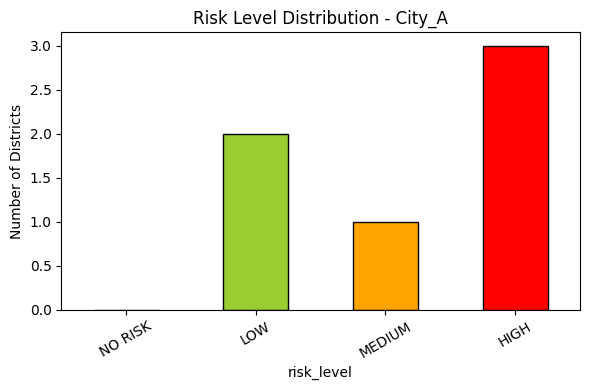

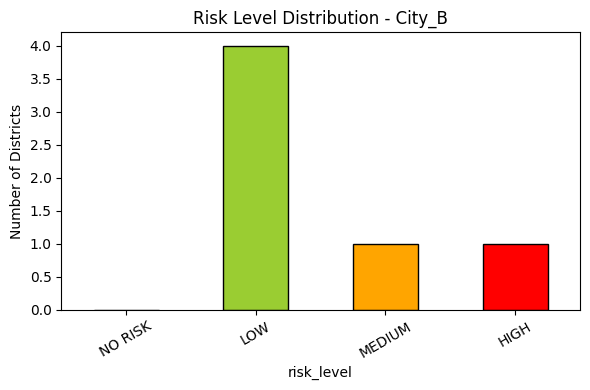

In [66]:
print("📈 Generating bar visualizations...")
visualize_risk_distribution(results_df)

In [67]:
# 2. Hourly Consumption Trend per District
def visualize_hourly_trends(df):
    for (city, district_id, date), group_data in df.groupby(['city','district_id',df['timestamp'].str[:10]]):
        plt.figure(figsize=(8,4))
        hourly_sum = group_data.groupby('hour')['consumption_kwh'].sum()
        peak_hour = hourly_sum.idxmax()
        plt.plot(hourly_sum.index, hourly_sum.values, marker="o", label="Total Consumption")
        plt.axvline(peak_hour, color="red", linestyle="--", label=f"Peak Hour {peak_hour}:00")
        plt.title(f"Hourly Consumption - {city} District {district_id} ({date})")
        plt.xlabel("Hour")
        plt.ylabel("Total Consumption (kWh)")
        plt.legend()
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()
        plt.savefig(f"output/plots/{city}_{district_id}_{date}_trend.png")
        plt.close()


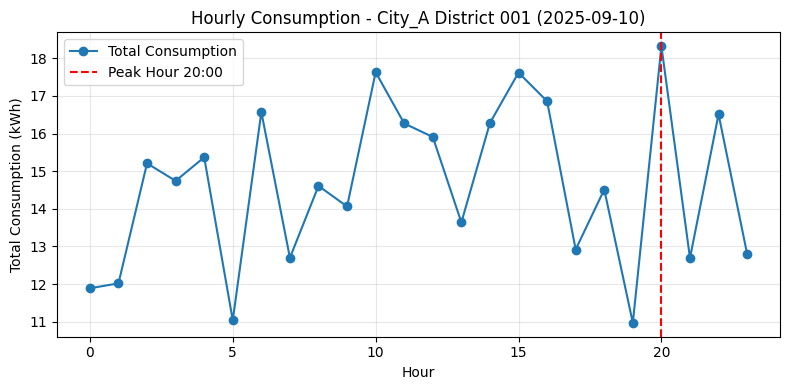

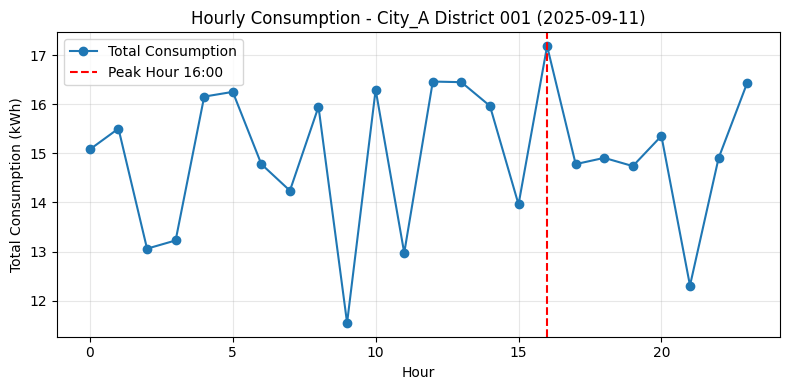

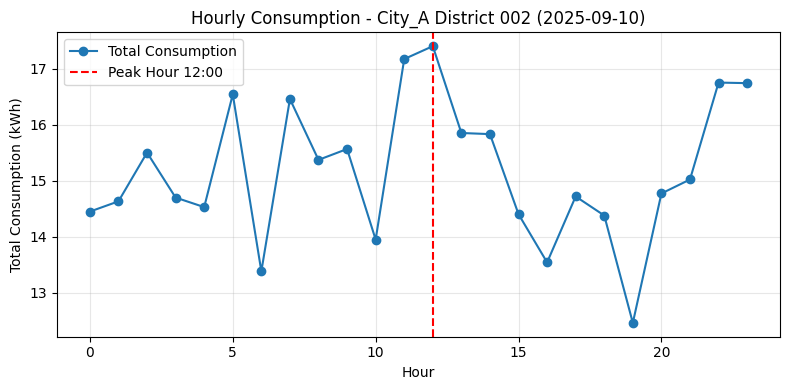

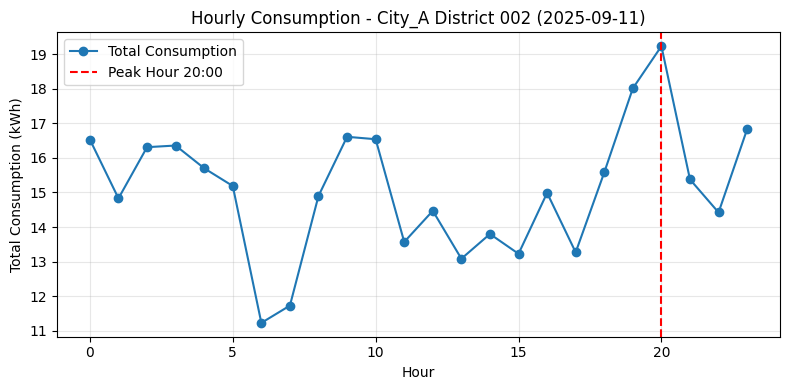

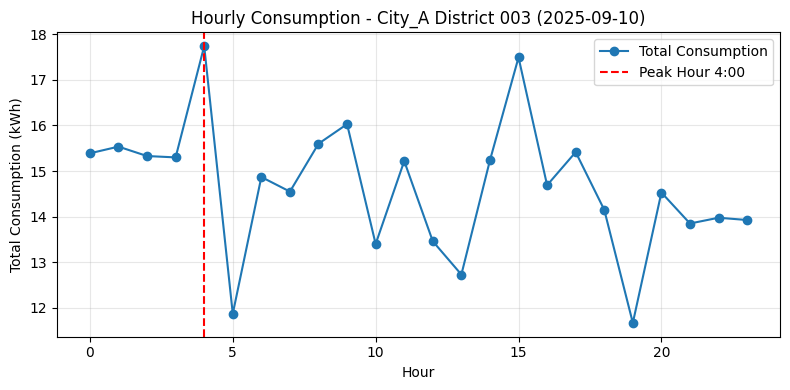

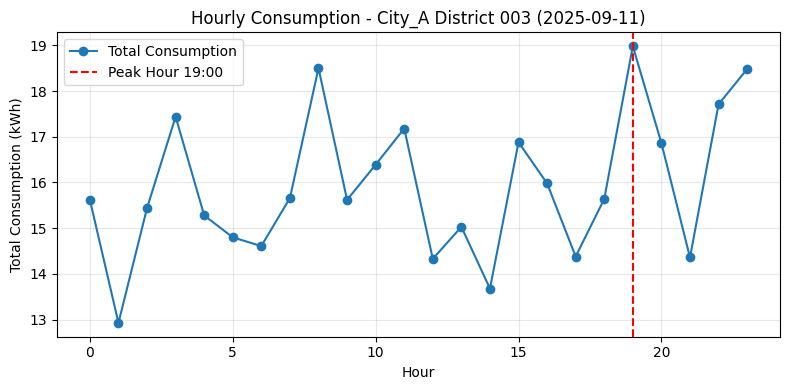

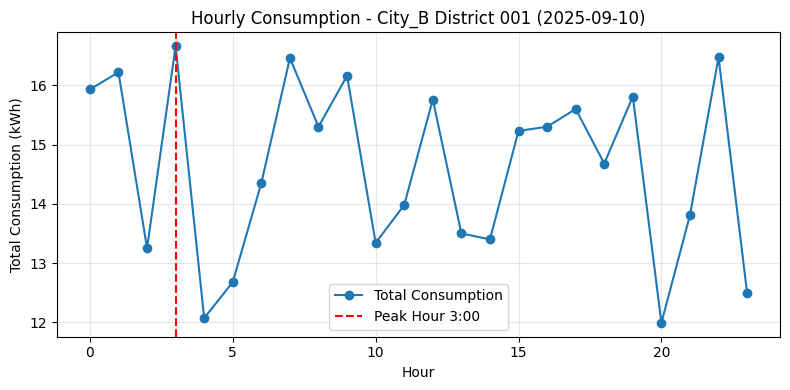

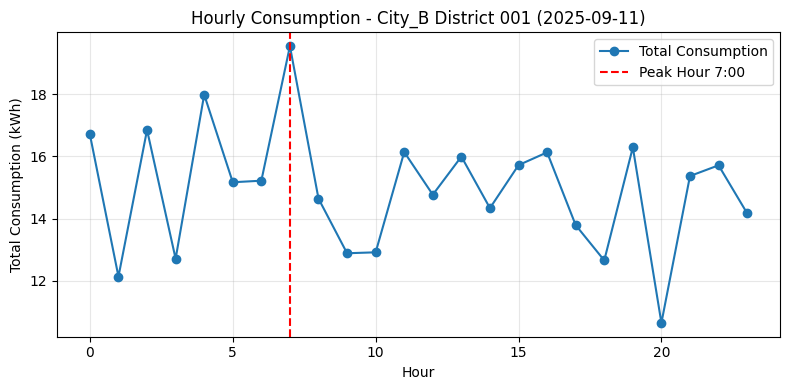

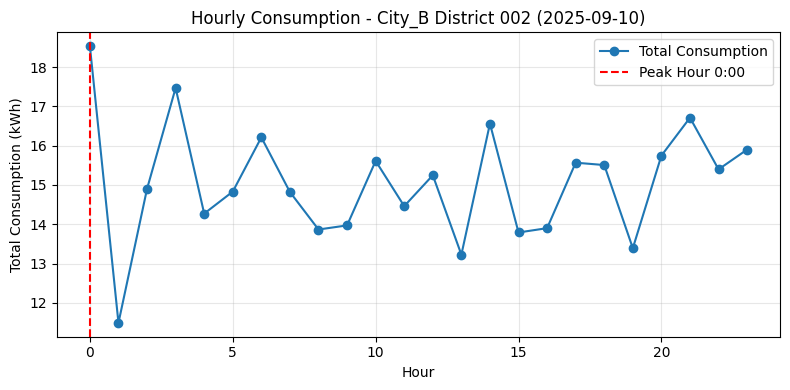

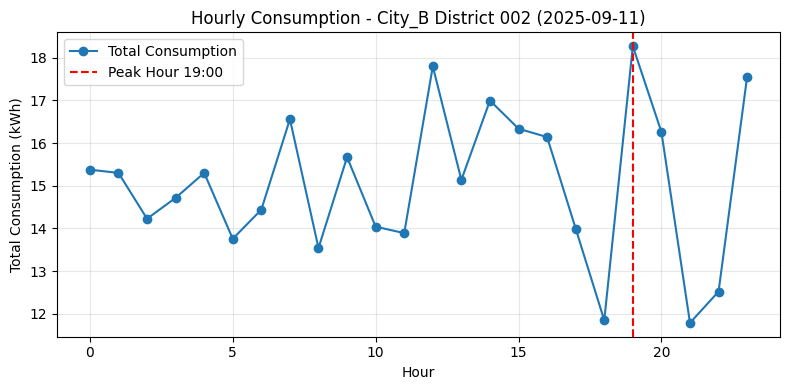

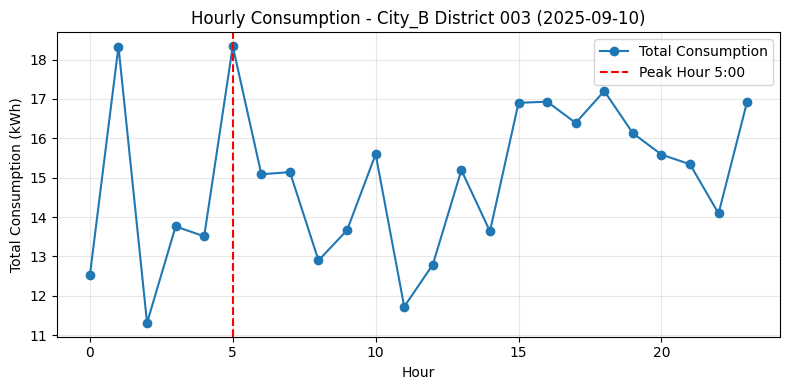

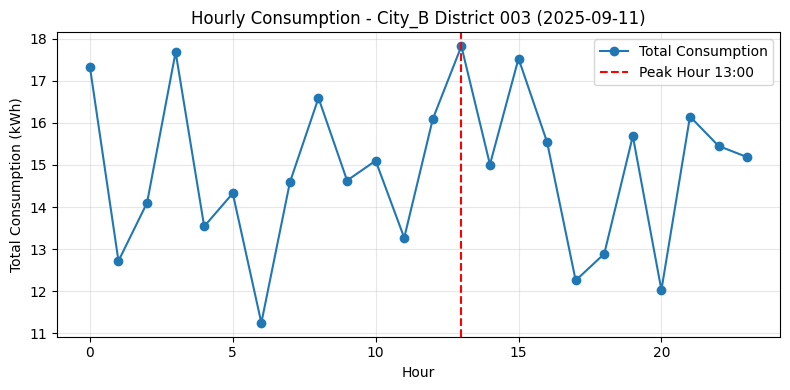

In [68]:
visualize_hourly_trends(df)

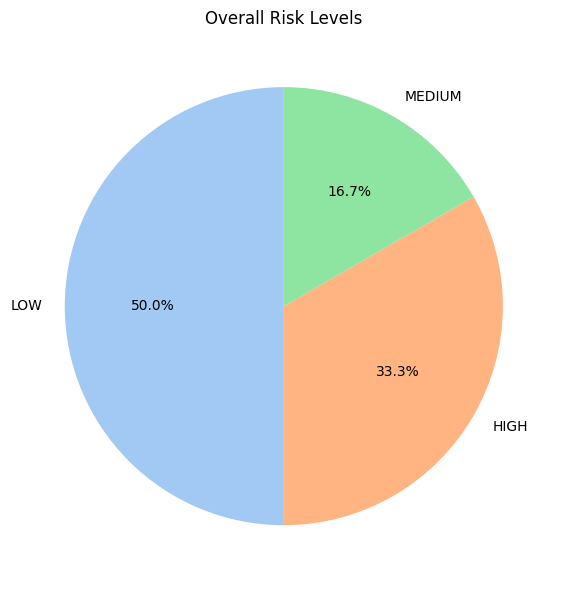

In [69]:
# 3. Pie Chart of Risk Levels
def visualize_risk_pie(results_df):
    risk_counts = results_df['risk_level'].value_counts()
    plt.figure(figsize=(6,6))
    plt.pie(risk_counts, labels=risk_counts.index, autopct='%1.1f%%', startangle=90,
            colors=sns.color_palette('pastel'))
    plt.title("Overall Risk Levels")
    plt.tight_layout()
    plt.show()
    plt.savefig("output/plots/risk_levels_pie.png")
    plt.close()
visualize_risk_pie(results_df)

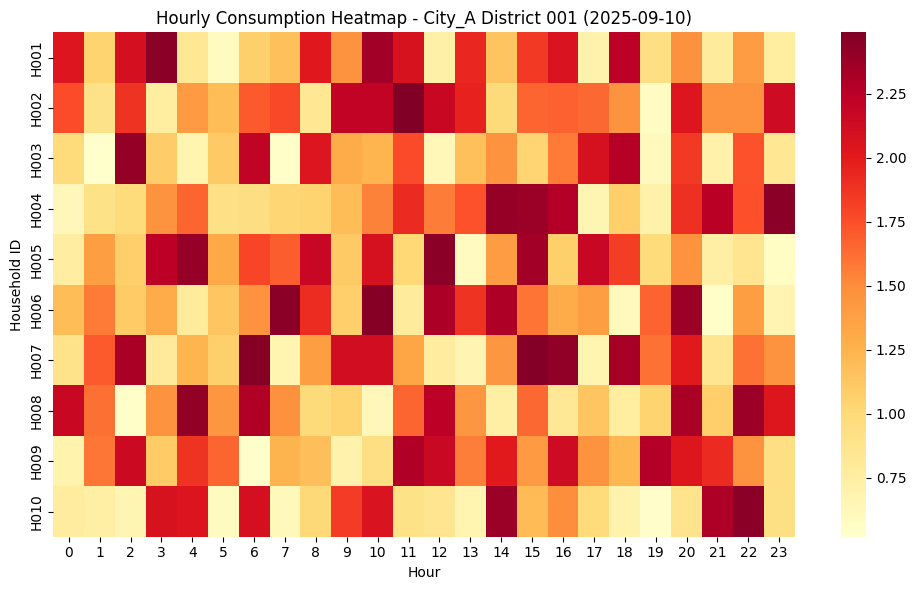

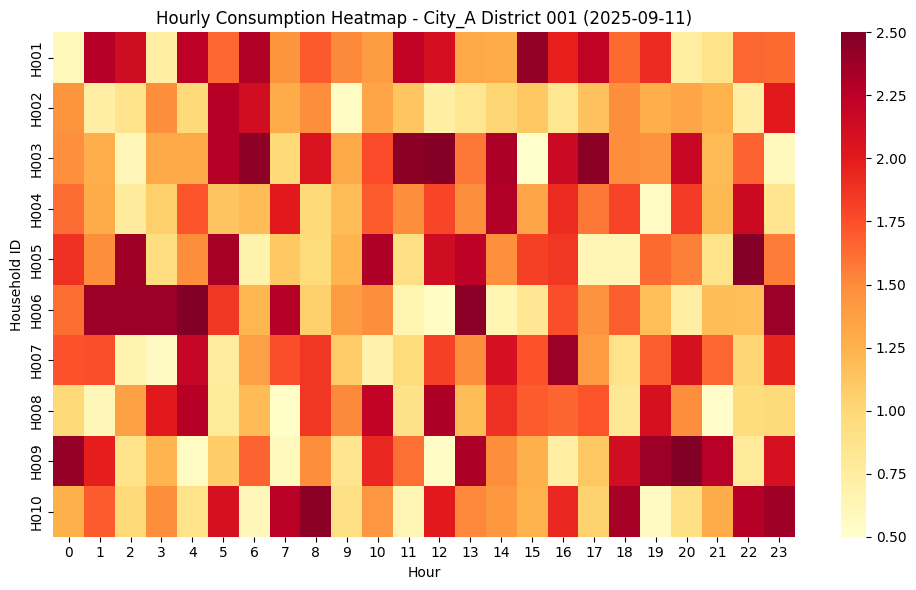

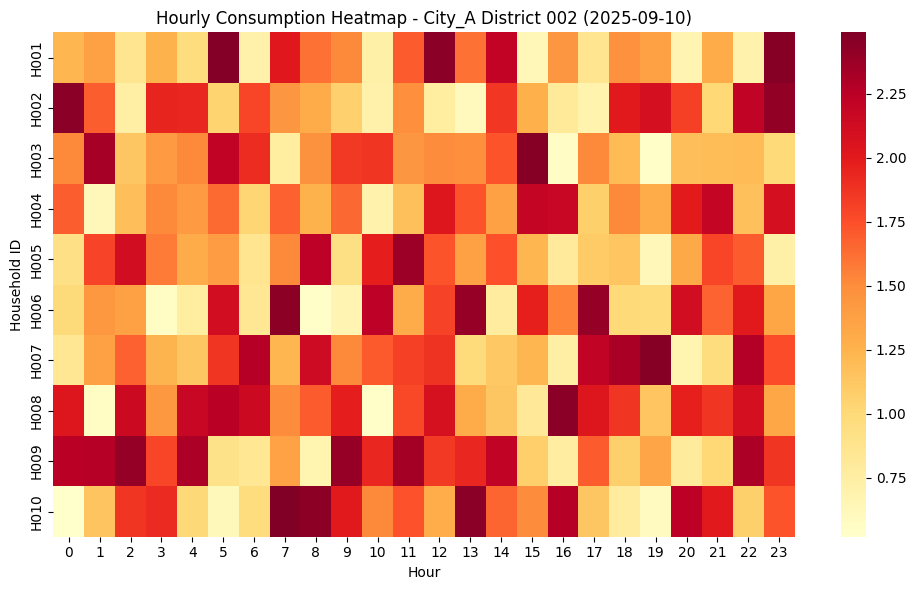

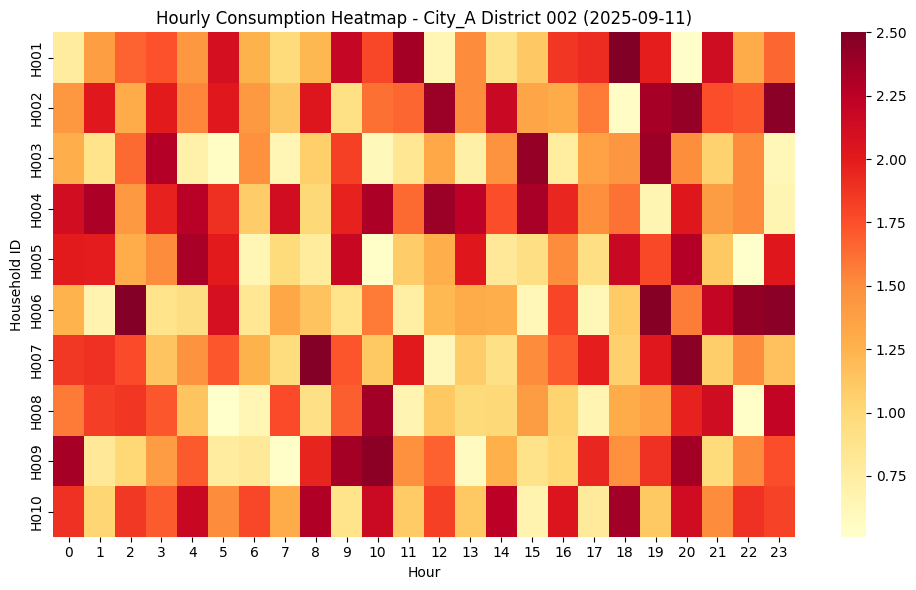

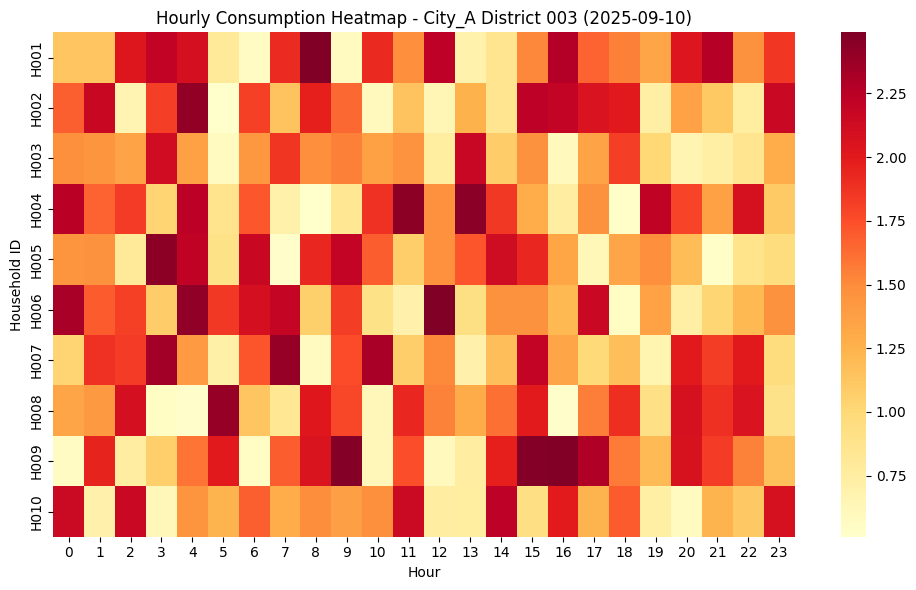

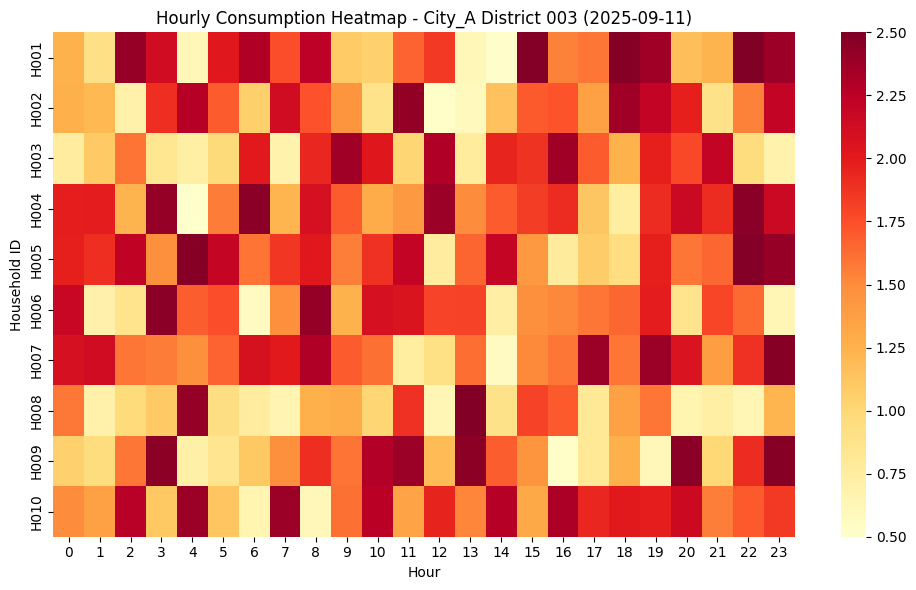

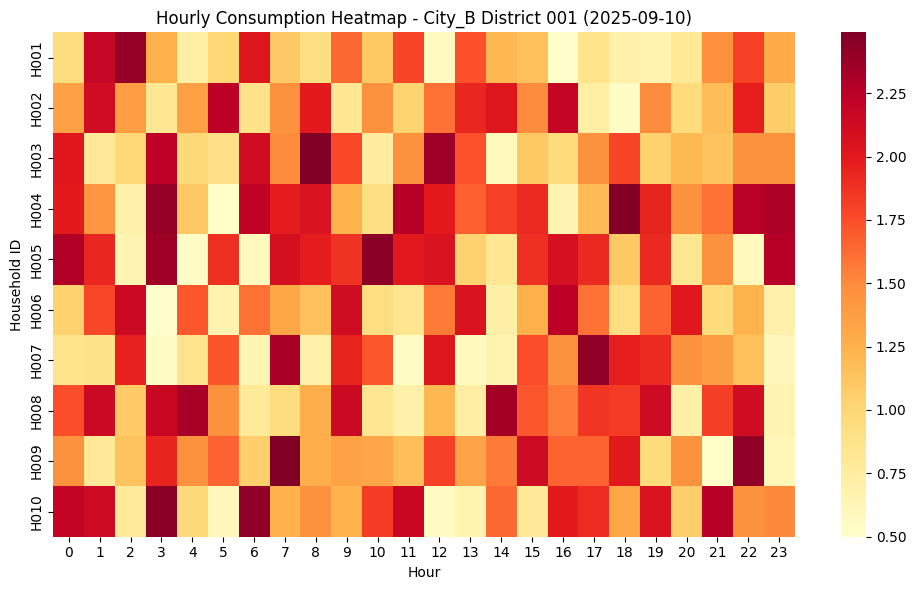

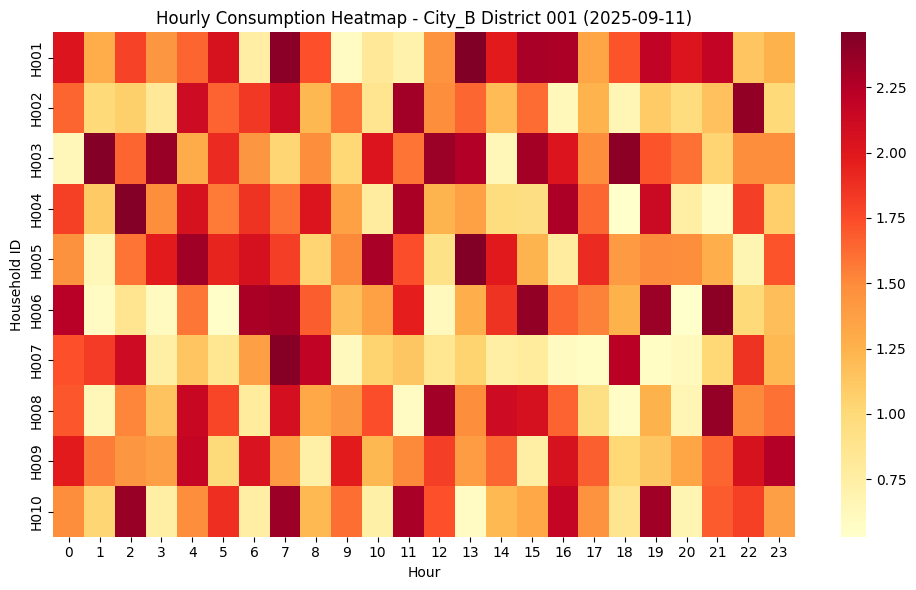

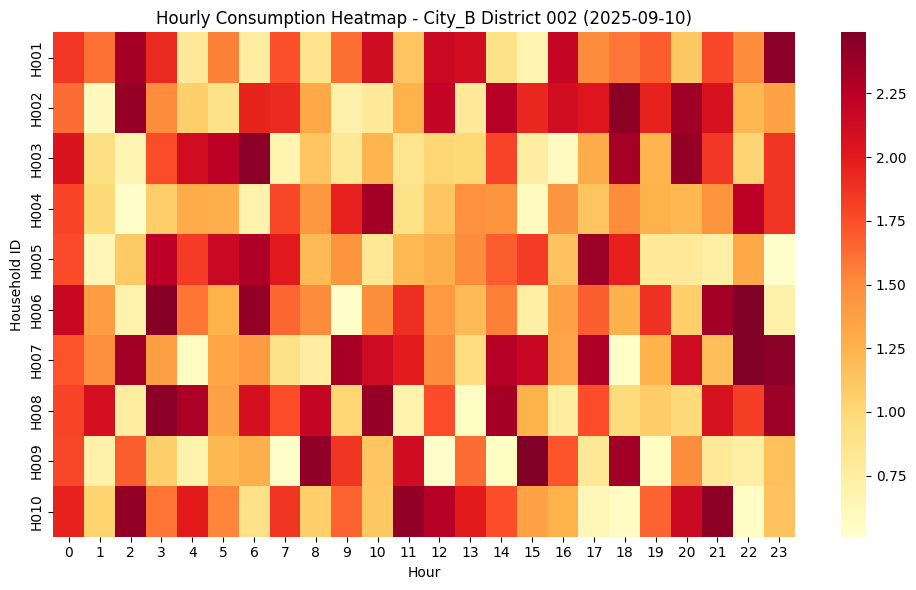

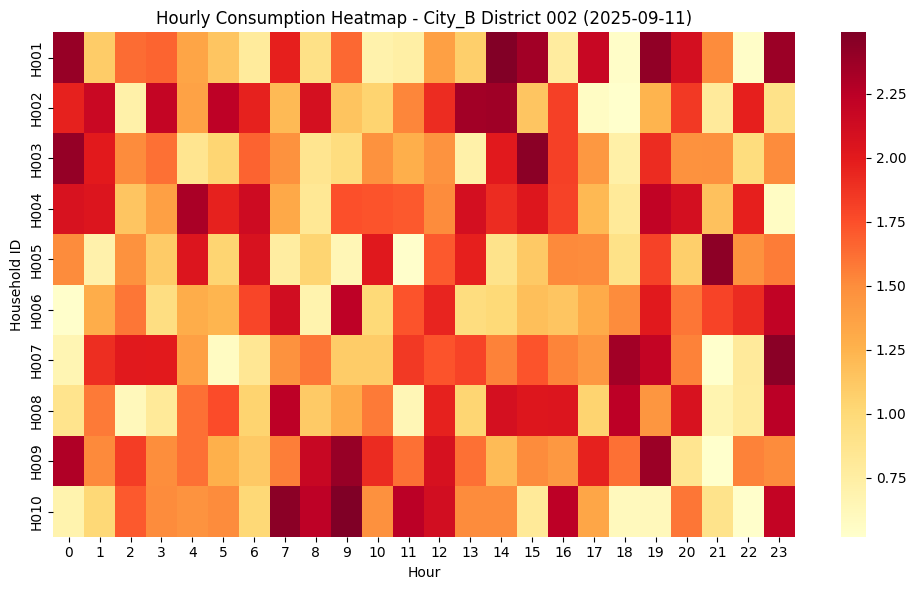

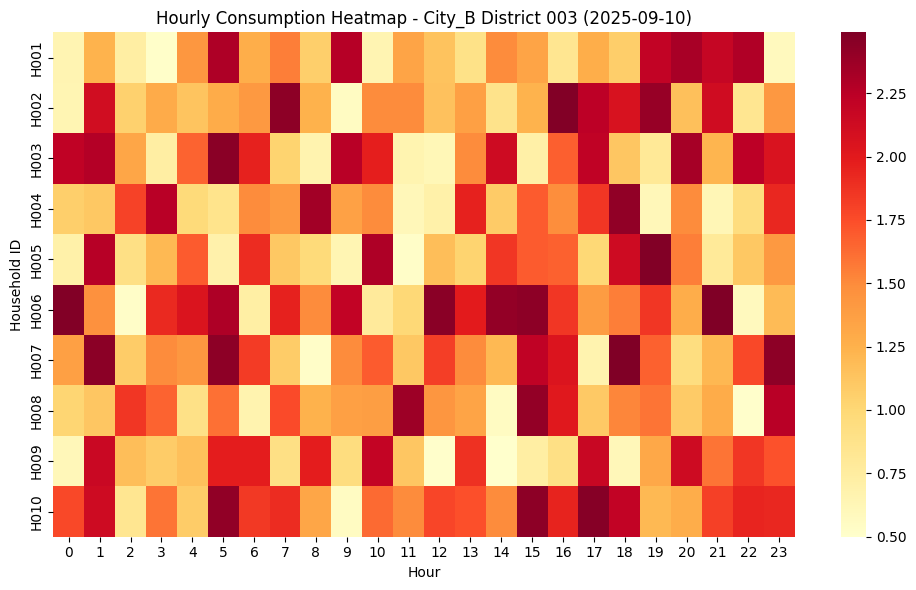

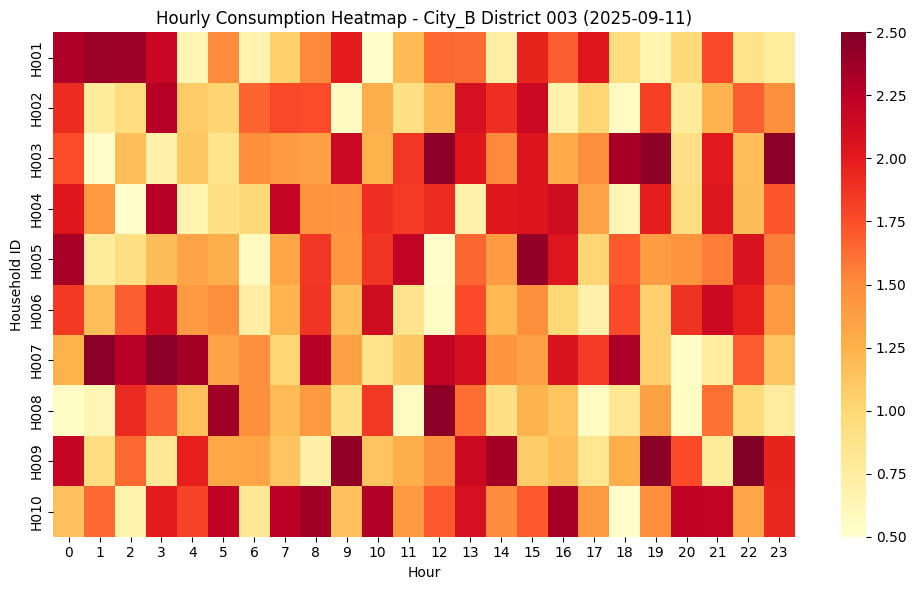

In [70]:
# 4. Heatmap of Household Consumption
def visualize_heatmap(df):
    for (city, district_id, date), group_data in df.groupby(['city','district_id',df['timestamp'].str[:10]]):
        pivot = group_data.pivot_table(index='household_id', columns='hour', values='consumption_kwh')
        plt.figure(figsize=(10,6))
        sns.heatmap(pivot, cmap="YlOrRd", annot=False)
        plt.title(f"Hourly Consumption Heatmap - {city} District {district_id} ({date})")
        plt.xlabel("Hour")
        plt.ylabel("Household ID")
        plt.tight_layout()
        plt.show()
        plt.savefig(f"output/plots/{city}_{district_id}_{date}_heatmap.png")
        plt.close()
visualize_heatmap(df)

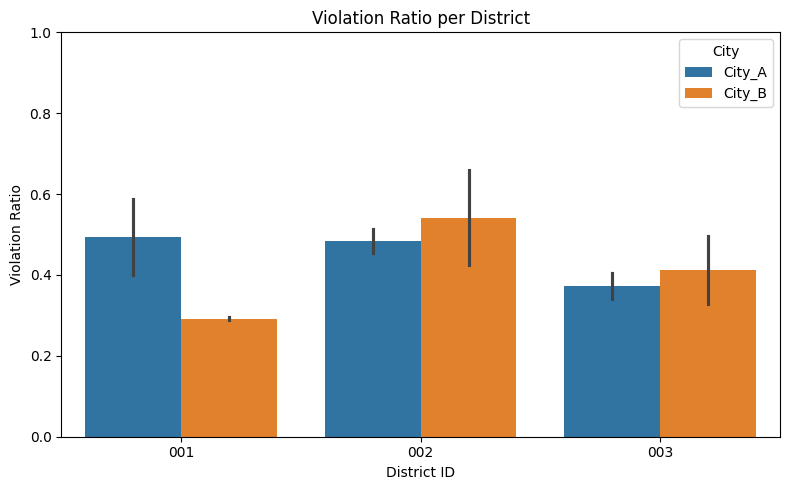

In [71]:
# 5. Violation Ratio per District
def visualize_violation_ratio(results_df):
    plt.figure(figsize=(8,5))
    sns.barplot(x='district_id', y='violation_ratio', hue='city', data=results_df)
    plt.title("Violation Ratio per District")
    plt.ylabel("Violation Ratio")
    plt.xlabel("District ID")
    plt.ylim(0, 1)
    plt.legend(title="City")
    plt.tight_layout()
    plt.show()
    plt.savefig("output/plots/violation_ratio.png")
    plt.close()
visualize_violation_ratio(results_df)

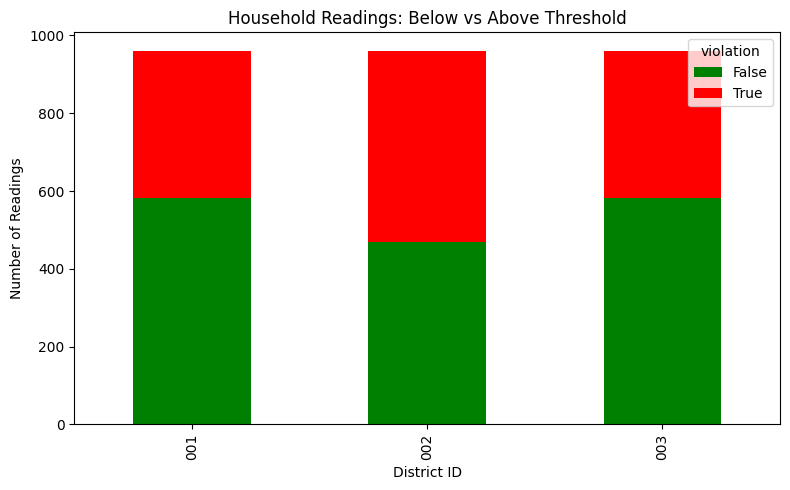

In [72]:
# 6. Stacked Bar of Violations
def visualize_stacked_violations(df):
    df_grouped = df.groupby(['district_id','violation']).size().unstack(fill_value=0)
    df_grouped.plot(kind='bar', stacked=True, figsize=(8,5), color=['green','red'])
    plt.title("Household Readings: Below vs Above Threshold")
    plt.ylabel("Number of Readings")
    plt.xlabel("District ID")
    plt.tight_layout()
    plt.show()
    plt.savefig("output/plots/stacked_violation.png")
    plt.close()
visualize_stacked_violations(df)

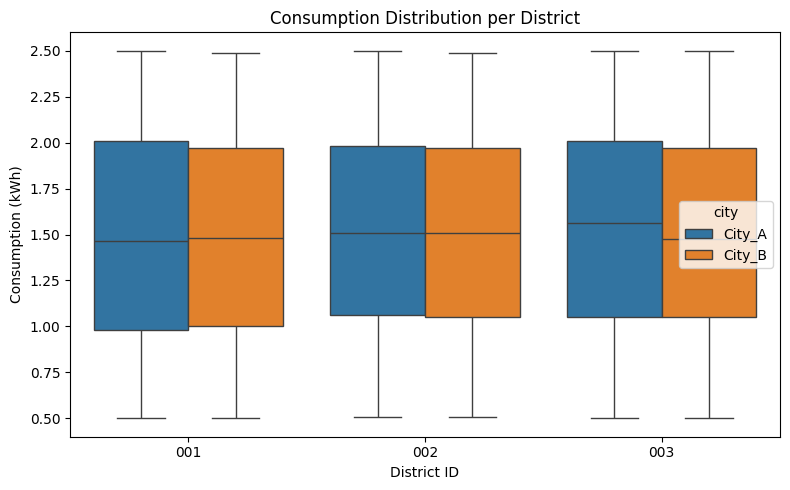

In [73]:
# 7. Boxplot of Consumption
def visualize_boxplot(df):
    plt.figure(figsize=(8,5))
    sns.boxplot(x='district_id', y='consumption_kwh', hue='city', data=df)
    plt.title("Consumption Distribution per District")
    plt.xlabel("District ID")
    plt.ylabel("Consumption (kWh)")
    plt.tight_layout()
    plt.show()
    plt.savefig("output/plots/boxplot_consumption.png")
    plt.close()
visualize_boxplot(df)

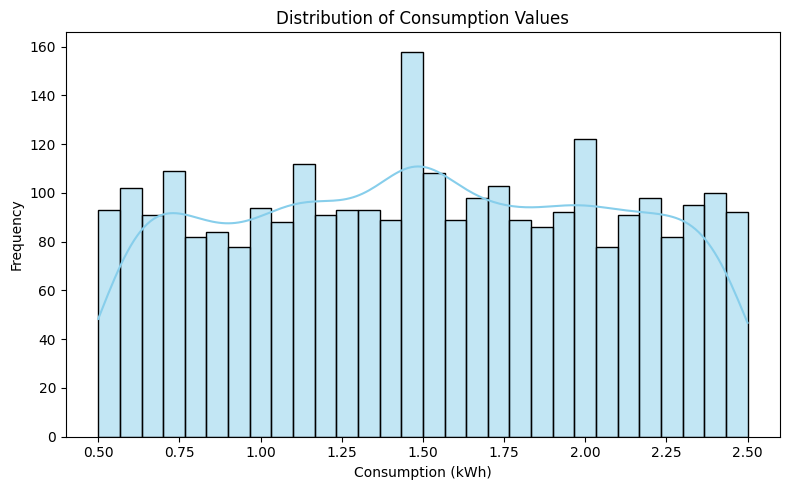

In [74]:
# 8. Histogram of Consumption
def visualize_histogram(df):
    plt.figure(figsize=(8,5))
    sns.histplot(df['consumption_kwh'], bins=30, kde=True, color='skyblue')
    plt.title("Distribution of Consumption Values")
    plt.xlabel("Consumption (kWh)")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()
    plt.savefig("output/plots/consumption_histogram.png")
    plt.close()
visualize_histogram(df)

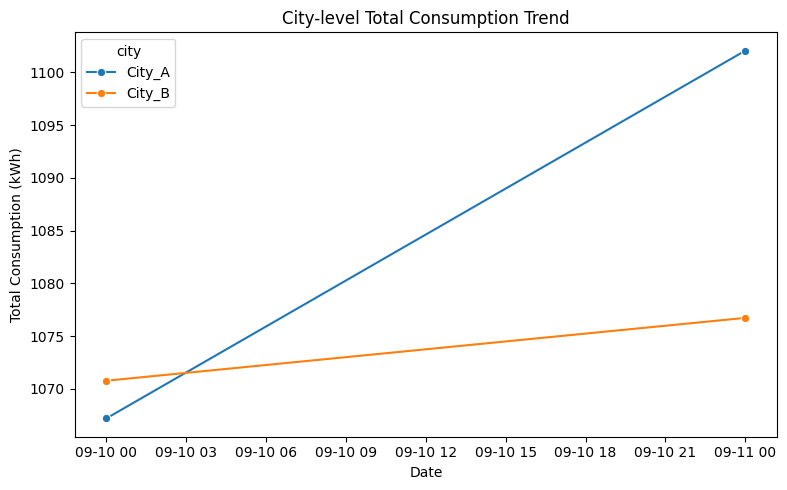

In [75]:
# 9. City-level Daily Trends
def visualize_city_trends(df):
    df['date'] = pd.to_datetime(df['timestamp']).dt.date
    city_daily = df.groupby(['city','date'])['consumption_kwh'].sum().reset_index()
    plt.figure(figsize=(8,5))
    sns.lineplot(data=city_daily, x='date', y='consumption_kwh', hue='city', marker='o')
    plt.title("City-level Total Consumption Trend")
    plt.xlabel("Date")
    plt.ylabel("Total Consumption (kWh)")
    plt.tight_layout()
    plt.show()
    plt.savefig("output/plots/city_daily_trend.png")
    plt.close()
visualize_city_trends(df)

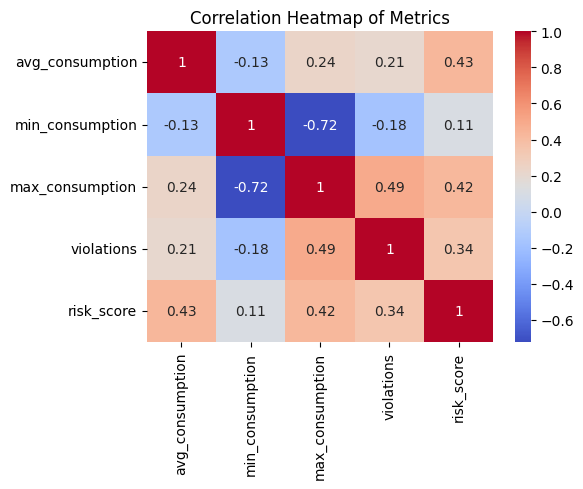

In [76]:
# 11. Correlation Heatmap
def visualize_correlation(results_df):
    plt.figure(figsize=(6,5))
    sns.heatmap(results_df[['avg_consumption','min_consumption','max_consumption','violations','risk_score']].corr(),
                annot=True, cmap="coolwarm")
    plt.title("Correlation Heatmap of Metrics")
    plt.tight_layout()
    plt.show()
    plt.savefig("output/plots/correlation_heatmap.png")
    plt.close()
visualize_correlation(results_df)

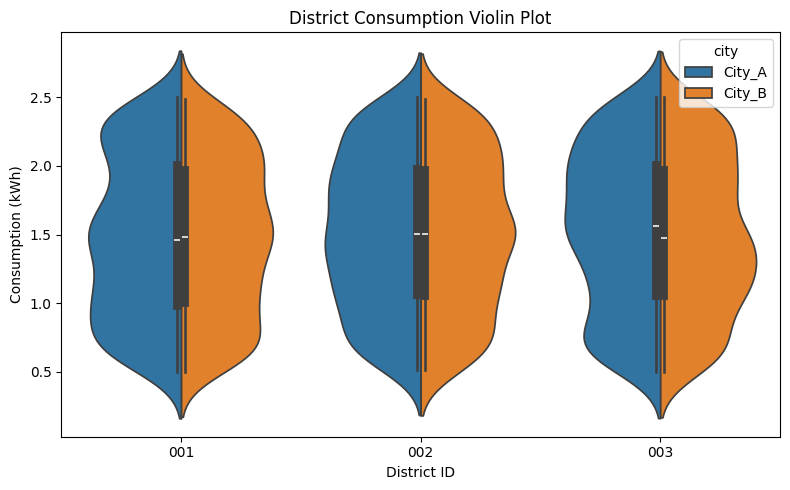

In [77]:
# 8. Violin Plot
def visualize_violinplot(df):
    plt.figure(figsize=(8,5))
    sns.violinplot(x='district_id', y='consumption_kwh', hue='city', data=df, split=True)
    plt.title("District Consumption Violin Plot")
    plt.xlabel("District ID")
    plt.ylabel("Consumption (kWh)")
    plt.tight_layout()
    plt.show()
    plt.savefig("output/plots/violin_consumption.png")
    plt.close()
visualize_violinplot(df)

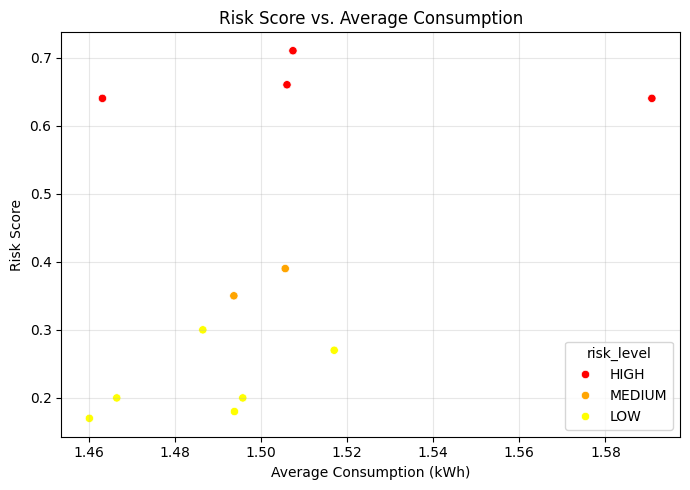

In [78]:
# 17. Scatter Plot: Risk Score vs Average Consumption
def visualize_risk_vs_consumption(results_df):
    plt.figure(figsize=(7,5))
    sns.scatterplot(data=results_df, x='avg_consumption', y='risk_score',
                    hue='risk_level', palette={"NO RISK":"green","LOW":"yellow","MEDIUM":"orange","HIGH":"red"})
    plt.title("Risk Score vs. Average Consumption")
    plt.xlabel("Average Consumption (kWh)")
    plt.ylabel("Risk Score")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    plt.savefig("output/plots/risk_vs_consumption.png")
    plt.close()
    plt.savefig("output/plots/risk_vs_consumption.png")
    plt.close()

visualize_risk_vs_consumption(results_df)

/tmp/ipython-input-3780019956.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




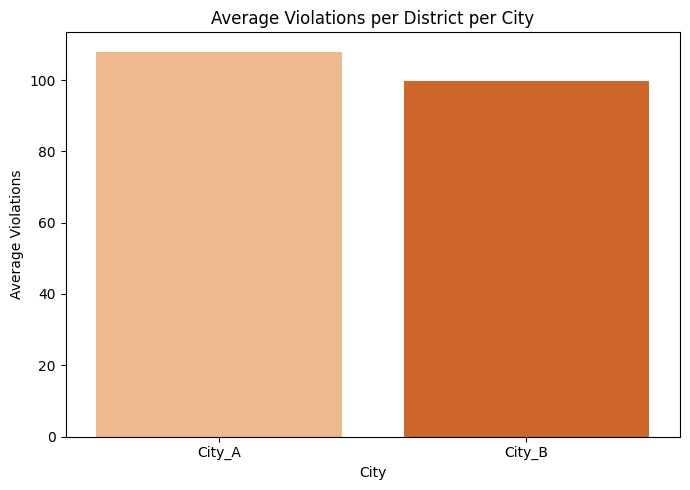

In [79]:
# 16. Average Violations per City
def visualize_avg_violations_per_city(results_df):
    plt.figure(figsize=(7,5))
    city_violations = results_df.groupby('city')['violations'].mean()
    sns.barplot(x=city_violations.index, y=city_violations.values, palette="Oranges")
    plt.title("Average Violations per District per City")
    plt.xlabel("City")
    plt.ylabel("Average Violations")
    plt.tight_layout()
    plt.show()
    plt.savefig("output/plots/city_avg_violations.png")
    plt.close()

visualize_avg_violations_per_city(results_df)

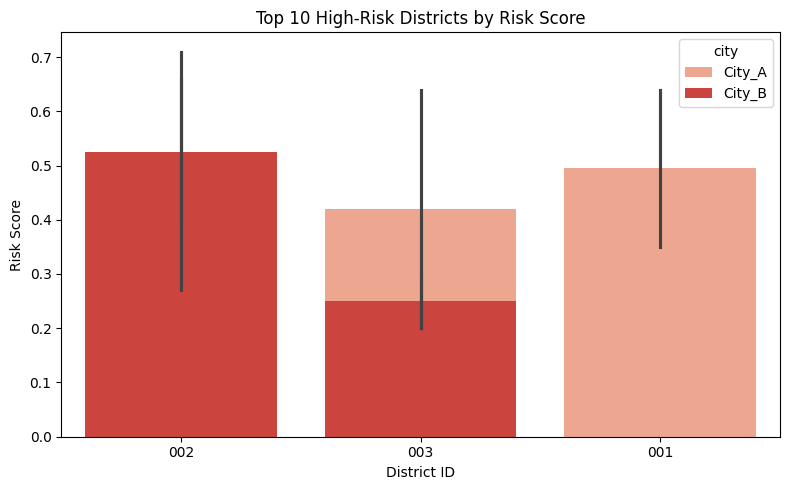

In [81]:
# 15. Top 10 Districts with Highest Risk Scores
def visualize_top_risk_districts(results_df):
    top_districts = results_df.sort_values('risk_score', ascending=False).head(10)
    plt.figure(figsize=(8,5))
    sns.barplot(x='district_id', y='risk_score', data=top_districts, hue='city', dodge=False, palette="Reds")
    plt.title("Top 10 High-Risk Districts by Risk Score")
    plt.xlabel("District ID")
    plt.ylabel("Risk Score")
    plt.tight_layout()
    plt.show()
    plt.savefig("output/plots/top10_risk_districts.png")
    plt.close()
visualize_top_risk_districts(results_df)

/tmp/ipython-input-3662162261.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




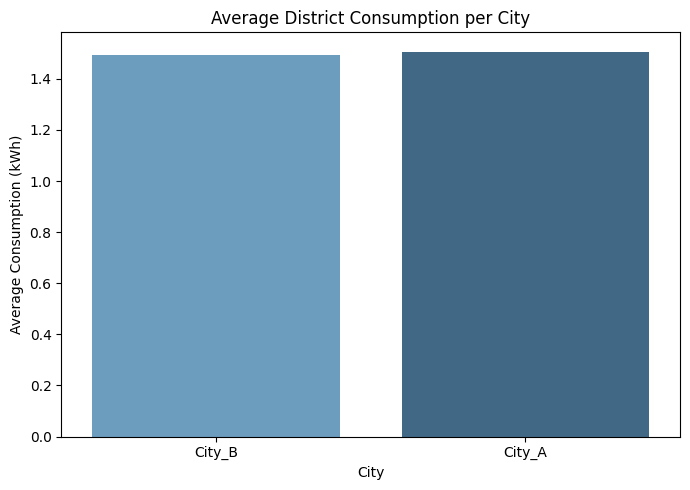

In [84]:
# 13. Average Consumption per City
def visualize_avg_consumption_per_city(results_df):
    plt.figure(figsize=(7,5))
    city_avg = results_df.groupby('city')['avg_consumption'].mean().sort_values()
    sns.barplot(x=city_avg.index, y=city_avg.values, palette='Blues_d')
    plt.title("Average District Consumption per City")
    plt.xlabel("City")
    plt.ylabel("Average Consumption (kWh)")
    plt.tight_layout()
    plt.show()
    plt.savefig("output/plots/city_avg_consumption.png")
    plt.close()

visualize_avg_consumption_per_city(results_df)